This implementation uses Bidirectional LSTMs to predict sales from time series data. Popular algorithms for time series forecasting include GRU, LSTM, Convolutional NN, and Bidirectional LSTM. After evaluating multiple algorithms and taking into account the presence of outliers from nearby holidays and busy trends around renewal notice periods, the Mean Absolute Error (MAE) was selected as the most suitable evaluation metric.

Bidirectional LSTM emerged as the best model, providing comparable results to Facebook's Prophet model. However, the resulting error margin of around $5,000 per day, which can represent 20-80% of daily sales, is too high for practical use by management.

Upon examining the residuals, the model struggles to learn patterns in the data before September 2020. This is likely due to the disruption in sales patterns caused by the onset of COVID-19 in April 2020. Although the model appears to learn patterns better after this period, it is still limited by the two years of data available. Additionally, a company price change could further impact the model's performance.

To improve the model, consider gathering more data, incorporating additional features, or testing alternative forecasting methods to better capture the patterns in the dataset.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import holidays

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop, Adagrad, SGD, Adam
from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.callbacks import ReduceLROnPlateau  # Learning Rate schedulers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers  # L2 Regularizers

# Import additional libraries for cross-validation and hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Load data and convert Date column to datetime datatype
sales = pd.read_csv('all_sales_2016_mar_2023.csv')
sales['Date'] = pd.to_datetime(sales['Date'])

# Create a new dataframe to obtain total sales per day
sales_data = sales[['Date', 'Total']]
sales_data = sales_data.groupby('Date')['Total'].sum().reset_index()
sales_data.set_index('Date', inplace=True)

# Resample the data to daily frequency
sales_data = sales_data.resample('D').sum()

#########
# Filter out weekends
sales_data_weekdays = sales_data[sales_data.index.to_series().apply(lambda x: x.weekday() not in [5, 6])]

# Resample the data to daily frequency, filling in missing values with 0
sales_data_weekdays = sales_data_weekdays.resample('B').sum()

us_holidays = holidays.US(years=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

# Filter out holidays
sales_data_weekdays = sales_data_weekdays[~sales_data_weekdays.index.isin(us_holidays)]

# Add features: day of the week, day of the month, week of the month, month of the year, and quarter
sales_data_weekdays['day_of_week'] = sales_data_weekdays.index.to_series().apply(lambda x: x.weekday())
sales_data_weekdays['day_of_month'] = sales_data_weekdays.index.to_series().apply(lambda x: x.day)
sales_data_weekdays['week_of_month'] = sales_data_weekdays.index.to_series().apply(lambda x: (x.day - 1) // 7 + 1)
sales_data_weekdays['month_of_year'] = sales_data_weekdays.index.to_series().apply(lambda x: x.month)
# sales_data_weekdays['quarter'] = sales_data_weekdays.index.to_series().apply(lambda x: x.quarter)

# One-hot encode day_of_week and month_of_year features
sales_data_weekdays = pd.get_dummies(sales_data_weekdays, columns=['day_of_week', 'month_of_year'])

# Scale the 'Total' column
total_scaler = MinMaxScaler(feature_range=(0, 1))
sales_data_weekdays['Total'] = total_scaler.fit_transform(sales_data_weekdays[['Total']])

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
sales_data_scaled = scaler.fit_transform(sales_data_weekdays.values)

# Create the dataset for training
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Define the look_back period
look_back = 5

# Split the data into training and testing sets
train_size = int(len(sales_data_scaled) * 0.8)
test_size = len(sales_data_scaled) - train_size
train_data, test_data = sales_data_scaled[0:train_size, :], sales_data_scaled[train_size - look_back:, :]

# Create the training and testing datasets
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape the input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))

# Create the neural network model

# Define the neural network model with hyperparameters as input arguments
def build_model(look_back=5, lstm_units=100, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_units, activation='relu', return_sequences=True), input_shape=(look_back, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    return model

# Create a KerasRegressor with the build_model function
model = KerasRegressor(build_fn=build_model)

# Define the parameters for hyperparameter tuning
param_grid = {
    'look_back': [3, 5, 7],  # test different look_back periods
    'lstm_units': [50, 100, 150],  # test different numbers of LSTM units
    'dropout_rate': [0.1, 0.2, 0.3],  # test different dropout rates
    'optimizer': ['adam', 'rmsprop'],  # test different optimizers
    'batch_size': [16, 32],  # test different batch sizes
    'epochs': [20, 40],  # test different numbers of epochs
}

# Perform cross-validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV with the KerasRegressor, parameter grid, and cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, verbose=2)

# Fit the GridSearchCV to the training data
grid_result = grid.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_result.best_params_
print("Best hyperparameters:", best_params)

# Build the best model using the best hyperparameters
best_model = build_model(
    look_back=best_params['look_back'],
    lstm_units=best_params['lstm_units'],
    dropout_rate=best_params['dropout_rate'],
    optimizer=best_params['optimizer'],
)

# Define Learning Rate Scheduler and Early Stopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the best model using the best hyperparameters
history = best_model.fit(
    X_train,
    y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=2,
    validation_split=0.1,
    callbacks=[lr_scheduler, early_stopping],
)

# Make predictions using the best model
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

# Invert the predictions
train_preds = total_scaler.inverse_transform(train_preds)
y_train = total_scaler.inverse_transform(y_train.reshape(-1, 1))
test_preds = total_scaler.inverse_transform(test_preds)
y_test = total_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the mean squared error and mean absolute error
train_mse = mean_squared_error(y_train, train_preds[:, 0])
train_mae = mean_absolute_error(y_train, train_preds[:, 0])
test_mse = mean_squared_error(y_test, test_preds[:, 0])
test_mae = mean_absolute_error(y_test, test_preds[:, 0])

print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

<ipython-input-13-8a485fe02839>:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model)


Streaming output truncated to the last 5000 lines.
Epoch 3/40
31/31 [==============================] - 1s 20ms/step - loss: 0.0671
Epoch 4/40
31/31 [==============================] - 1s 20ms/step - loss: 0.0660
Epoch 5/40
31/31 [==============================] - 1s 21ms/step - loss: 0.0653
Epoch 6/40
31/31 [==============================] - 1s 19ms/step - loss: 0.0675
Epoch 7/40
31/31 [==============================] - 1s 18ms/step - loss: 0.0658
Epoch 8/40
31/31 [==============================] - 1s 20ms/step - loss: 0.0650
Epoch 9/40
31/31 [==============================] - 1s 19ms/step - loss: 0.0650
Epoch 10/40
31/31 [==============================] - 1s 19ms/step - loss: 0.0660
Epoch 11/40
31/31 [==============================] - 1s 19ms/step - loss: 0.0638
Epoch 12/40
31/31 [==============================] - 1s 20ms/step - loss: 0.0642
Epoch 13/40
31/31 [==============================] - 1s 20ms/step - loss: 0.0647
Epoch 14/40
31/31 [==============================] - 1s 19ms/step

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__a

Epoch 1/40
91/91 [==============================] - 7s 29ms/step - loss: 0.1067
Epoch 2/40
91/91 [==============================] - 3s 29ms/step - loss: 0.0754
Epoch 3/40
91/91 [==============================] - 3s 29ms/step - loss: 0.0751
Epoch 4/40
91/91 [==============================] - 3s 36ms/step - loss: 0.0738
Epoch 5/40
91/91 [==============================] - 3s 33ms/step - loss: 0.0735
Epoch 6/40
91/91 [==============================] - 3s 28ms/step - loss: 0.0732
Epoch 7/40
91/91 [==============================] - 3s 30ms/step - loss: 0.0718
Epoch 8/40
91/91 [==============================] - 3s 29ms/step - loss: 0.0714
Epoch 9/40
91/91 [==============================] - 3s 37ms/step - loss: 0.0725
Epoch 10/40
91/91 [==============================] - 3s 33ms/step - loss: 0.0711
Epoch 11/40
91/91 [==============================] - 3s 29ms/step - loss: 0.0721
Epoch 12/40
91/91 [==============================] - 3s 31ms/step - loss: 0.0707
Epoch 13/40
91/91 [==================

Best Results were

- Train MSE: 36237864.82742058
- Train MAE: 4794.283688335129
- Test MSE: 78819138.43680252
- Test MAE: 6726.812776656937

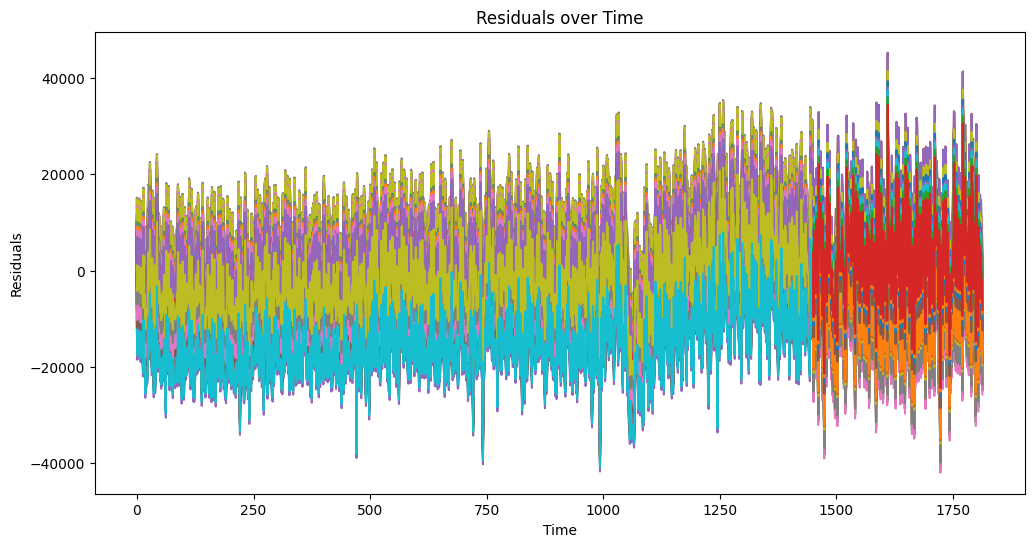

In [ ]:
train_residuals = y_train - train_preds[:, 0]
test_residuals = y_test - test_preds[:, 0]
plt.figure(figsize=(12, 6))
plt.plot(train_residuals, label='Train Residuals')
plt.plot(np.arange(len(train_residuals), len(train_residuals) + len(test_residuals)), test_residuals, label='Test Residuals')
plt.title("Residuals over Time")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()


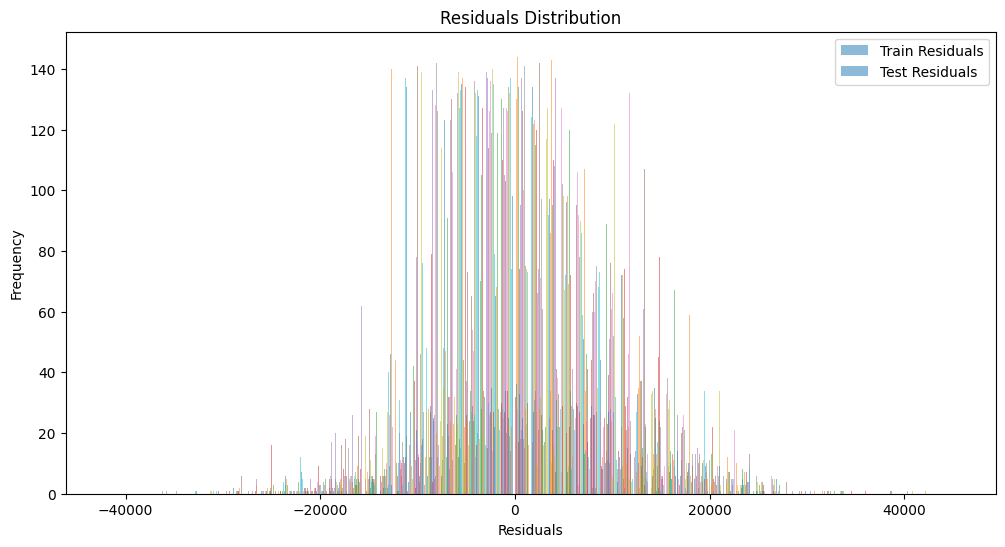

In [ ]:

plt.figure(figsize=(12, 6))
plt.hist(train_residuals, bins=50, alpha=0.5, label='Train Residuals')
plt.hist(test_residuals, bins=50, alpha=0.5, label='Test Residuals')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()


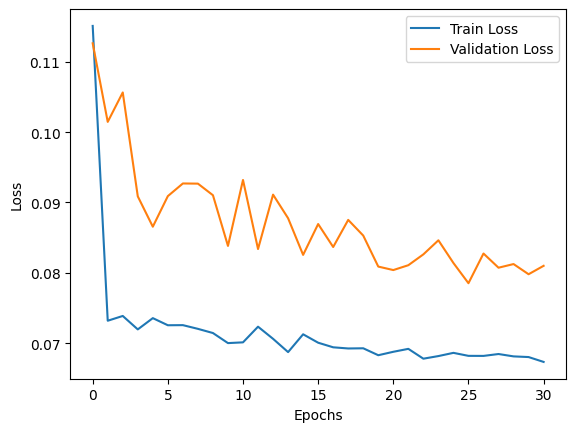

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

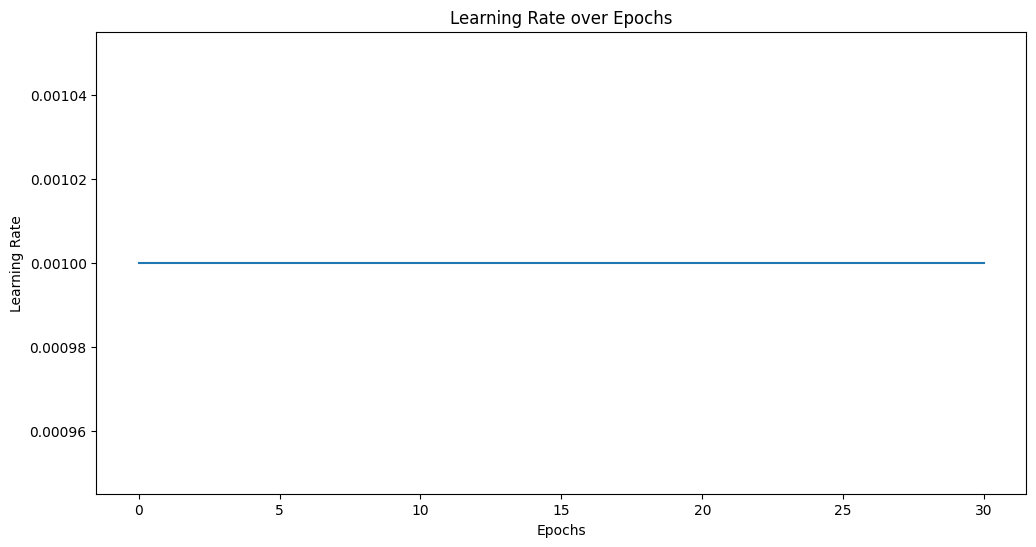

In [ ]:
import matplotlib.pyplot as plt

# Extract the learning rate history
learning_rates = history.history['lr']

# Plot the learning rate over epochs
plt.figure(figsize=(12, 6))
plt.plot(learning_rates)
plt.title("Learning Rate over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.show()

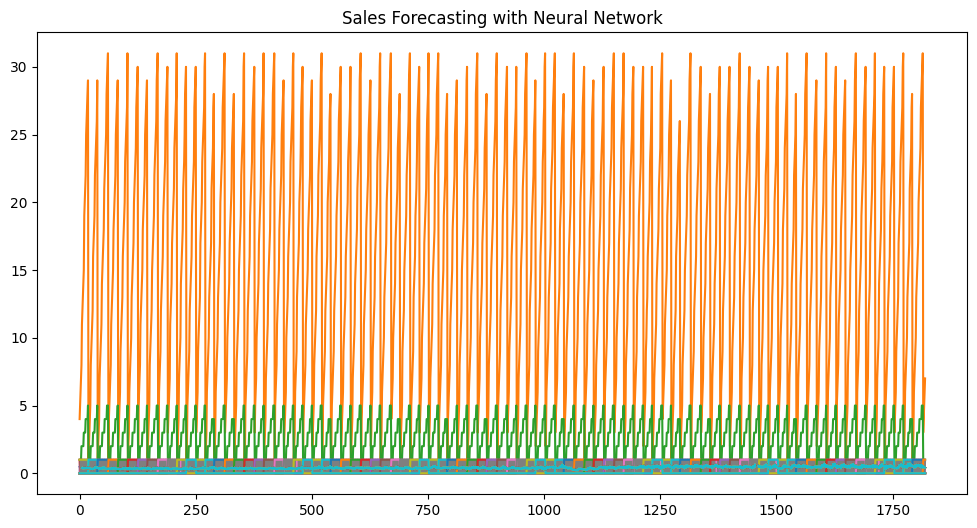

In [ ]:
train_plot = np.empty_like(sales_data_scaled)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_preds) + look_back, :] = train_preds

test_plot = np.empty_like(sales_data_scaled)
test_plot[:, :] = np.nan
test_plot[len(train_preds) + (look_back * 2) + 1:len(sales_data_scaled), :] = test_preds[:len(test_plot) - (len(train_preds) + (look_back * 2) + 1)]

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(sales_data_scaled), label='Actual')
plt.plot(train_plot, label='Training Predictions')
plt.plot(test_plot, label='Test Predictions')
#plt.legend()
plt.title("Sales Forecasting with Neural Network")
plt.show()


Outcome: It looks like the model has difficulty finding patterns in older data past a year and a half. Shifts from pricing increases look to have changed consumer behavior, as well as COVID 2020 impact is visible starting April 2020. This may confuse the model. Considering that an additional price increase was implemented early 2023 it is advisable to collect more data to improve the predictions.